In [28]:
%%time
import numpy as np
import matplotlib.pyplot as plt

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 10.7 µs


In [2]:
import torch
torch.manual_seed(0) #Establece la semilla para generar números aleatorios. Devuelve un objeto torch.Generator .
from torch import optim, nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset, random_split #  random_split: Divide el dataset en dos
# Gráficos

from jupyterthemes import jtplot
jtplot.style()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


/root/anaconda3/envs/gpu/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180544224/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
print(torch.cuda.is_available())


False


## Datasets y DataLoaders

In [5]:
PATH = '/home/matasietephi/Documentos/jupyterNOTEBOOK/cifar-10-batches-py'
TRAIN_SIZE = 50000
VAL_SIZE = 5000
TEST_SIZE = 5000
MINIBATCH_SIZE = 512
# Transformaciones aleatorias de cada minibatch 
transform_cifar10_train = T.Compose([
                T.RandomHorizontalFlip(p=0.3), # Con una probabilidad el 30% realice un rotación de la imagen 
                T.ColorJitter(brightness=0.1, contrast=0.1, hue=0.05), # Ajuste de brillo y contraste 
                T.RandomApply([T.RandomRotation(10), T.Resize(40), T.CenterCrop(32)]), # Rotación de 10 grados 
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, .0243, 0.262]) # Desviación media y standar para los canales RGB
                ])
# Al aplicar cada mini batch se aplican una serie de transformaciones 
transform_cifar10_test = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, .0243, 0.262])
                ])

## *  Descarga de Dataset 

In [6]:
# Entrenamiento
cifar10_train = datasets.CIFAR10(PATH, train=True, download=True,transform=transform_cifar10_train)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, shuffle = True)

Files already downloaded and verified


In [7]:
#Validación
test_dataset = datasets.CIFAR10(PATH, train=False, download=True, transform=transform_cifar10_test) # Transformaciones de Prueba 
val_dataset, test_dataset = random_split(test_dataset, [VAL_SIZE, TEST_SIZE]) # Realizamos la división del Datasets

Files already downloaded and verified


In [8]:
val_loader = DataLoader(val_dataset, batch_size=MINIBATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=MINIBATCH_SIZE, shuffle=True)

In [9]:
len(val_loader.dataset)

5000

In [10]:
# verifica que los dataloader están bien generados
for i,(x, y) in enumerate(test_loader): 
    print(i, x.shape, y.shape)

0 torch.Size([512, 3, 32, 32]) torch.Size([512])
1 torch.Size([512, 3, 32, 32]) torch.Size([512])
2 torch.Size([512, 3, 32, 32]) torch.Size([512])
3 torch.Size([512, 3, 32, 32]) torch.Size([512])
4 torch.Size([512, 3, 32, 32]) torch.Size([512])
5 torch.Size([512, 3, 32, 32]) torch.Size([512])
6 torch.Size([512, 3, 32, 32]) torch.Size([512])
7 torch.Size([512, 3, 32, 32]) torch.Size([512])
8 torch.Size([512, 3, 32, 32]) torch.Size([512])
9 torch.Size([392, 3, 32, 32]) torch.Size([392])


## Muestra de Datos

La imagen muestreada representa un: frog


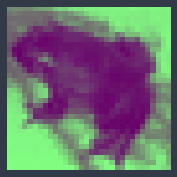

In [11]:
classes =train_loader.dataset.classes
def plot_figure(imagen):
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image- image.min()) / (image.max() - image.min() )
plot_figure(image)

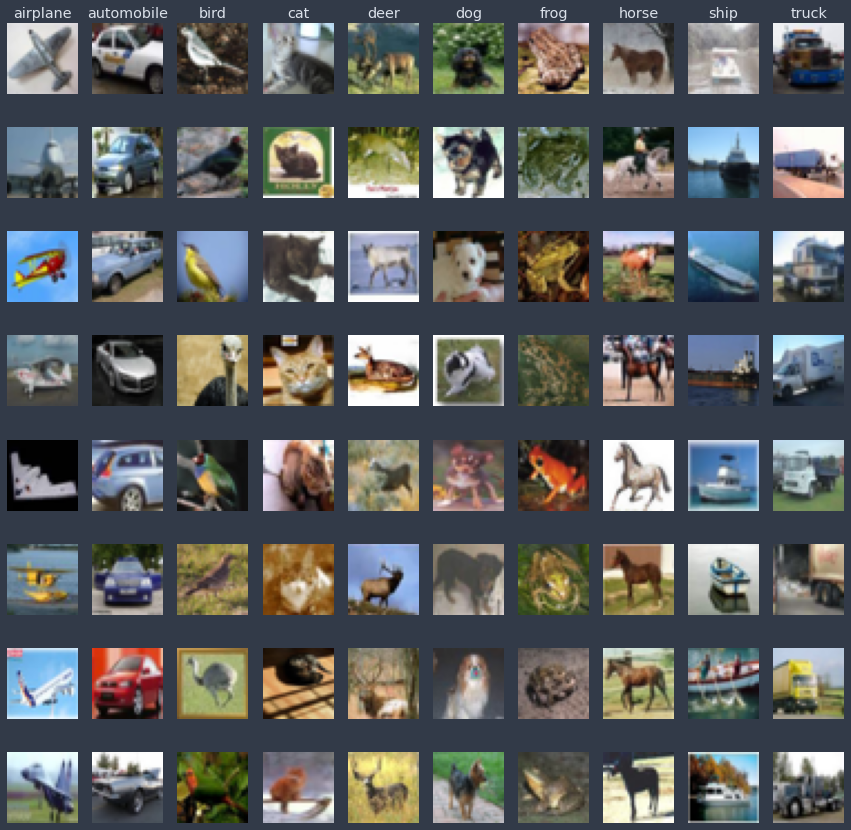

In [12]:
# Muestra la grilla de todo el DataSet
def plot_cifar10_grid():
    classes = train_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(train_loader.dataset.targets))
        sample_idx= np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idx):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(train_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()
    
plot_cifar10_grid()
        

In [13]:
len(val_loader)

10

In [14]:
def accuracy(model, loader):
    '''
    model - PyTorch model
    loader - PyTorch dataloader
    
    Returns:
    
    '''
    correct = 0
    total = 0
    cost = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            _, pred = scores.max(dim=1)
            correct += (pred == y).sum()
            total += pred.size(0)
        return cost/len(loader), float(correct)/total

In [15]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        acc_ = ((torch.argmax(scores, dim=1) == y).sum()/scores.size(0)) 
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss
        
#         accuracies.append(acc.item())
        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies   

In [16]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        acc_ = ((torch.argmax(scores, dim=1) == y).sum()/scores.size(0)) 
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss
        
#         accuracies.append(acc.item())
        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies     

In [17]:
def train(model, optimiser, scheduler = None, epochs = 100):
    model = model.to(device = device)
    val_loss_history = []
    train_loss_history = []
    val_acc_history = []
    train_acc_history = []
    lrs = []
    train_cost = 0.
    val_cost = 0.
    train_cost_acum = 0
    for epoch in range(epochs):
        train_correct_num  = 0
        train_total = 0
        train_cost_acum = 0
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            #if using scheduler
            if scheduler: scheduler.step()
                
            train_correct_num += (torch.argmax(scores, dim=1) == y).sum()
            train_total += scores.size(0)        
            train_cost_acum += cost.item()
            train_acc = float(train_correct_num)/train_total  
#             train_cost = train_cost_acum/mb
            val_cost, val_acc = accuracy(model, val_loader)

            val_loss_history.append(val_cost)
            train_loss_history.append(cost.item())
            val_acc_history.append(val_acc)
            train_acc_history.append(train_acc)
#             lrs.append(scheduler.get_last_lr()[0])
            lrs.append(optimiser.param_groups[0]["lr"])
        
        #f'last lr: {scheduler.get_last_lr()[0]:6f},
        
        train_acc = float(train_correct_num)/train_total
        train_cost = train_cost_acum/len(train_loader)
        print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f}, total: {train_total},'
                      f' lr: {optimiser.param_groups[0]["lr"]:.6f}')
        
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs

In [18]:
conv_k_3 = lambda channel1, channel2, stride: nn.Conv2d(channel1, channel2, stride = stride, kernel_size=3, padding=1)


In [19]:
class residual_block(nn.Module):
    '''

    '''
    def __init__(self, in_channel, out_channel, stride=1, change_size = True):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, out_channel, stride)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = conv_k_3(out_channel, out_channel, 1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        #for changing activation map sizes
        self.change_size = change_size
        if change_size:
            self.residual = nn.Sequential(nn.Conv2d(in_channel, 
                                                    out_channel, 
                                                    kernel_size=1,
                                                    stride=stride),
                                         nn.BatchNorm2d(out_channel)
                                         )      
    def forward(self, x):
        identity = x if not self.change_size else self.residual(x)
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y += identity
        return F.relu(y)

In [20]:
class ResNet56(nn.Module):
    def __init__(self, n=9, num_classes=10):
        super().__init__()
        self.conv1 = conv_k_3(3, 16, stride = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.block1 = self.create_block(n=9, in_channel=16, 
                                        out_channel=16, stride=1, 
                                        change_size=False)
        self.block2 = self.create_block(n=9, in_channel=16, 
                                        out_channel=32, stride=2)
        self.block3 = self.create_block(n=9, in_channel=32, 
                                        out_channel=64, stride=2)
        self.fc = nn.Linear(64, num_classes)

    def create_block(self, n, in_channel, out_channel, stride, change_size=True):
        block = [residual_block(in_channel, out_channel, stride, change_size=change_size)]
        for i in range(n-1):
            block.append(residual_block(out_channel, out_channel, stride=1, change_size=False))
        return nn.Sequential(*block)   
        
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.block3(self.block2(self.block1(y)))
        y = F.adaptive_avg_pool2d(y, 1)
        return self.fc(y.view(y.size(0), -1))      
       

In [21]:
model_resnet56 = ResNet56()


In [22]:
from torchinfo import summary

summary(ResNet56())

Layer (type:depth-idx)                   Param #
ResNet56                                 --
├─Conv2d: 1-1                            448
├─BatchNorm2d: 1-2                       32
├─Sequential: 1-3                        --
│    └─residual_block: 2-1               --
│    │    └─Conv2d: 3-1                  2,320
│    │    └─BatchNorm2d: 3-2             32
│    │    └─Conv2d: 3-3                  2,320
│    │    └─BatchNorm2d: 3-4             32
│    └─residual_block: 2-2               --
│    │    └─Conv2d: 3-5                  2,320
│    │    └─BatchNorm2d: 3-6             32
│    │    └─Conv2d: 3-7                  2,320
│    │    └─BatchNorm2d: 3-8             32
│    └─residual_block: 2-3               --
│    │    └─Conv2d: 3-9                  2,320
│    │    └─BatchNorm2d: 3-10            32
│    │    └─Conv2d: 3-11                 2,320
│    │    └─BatchNorm2d: 3-12            32
│    └─residual_block: 2-4               --
│    │    └─Conv2d: 3-13                 2,320
│    

In [23]:
# model_resnet56 = ResNet56()
optimiser_resnet56 = torch.optim.SGD(model_resnet56.parameters(),
                                     lr=0.1, momentum=0.95,
                                     weight_decay=1e-4)

In [24]:
lg_lr, losses, accuracies = find_lr(model_resnet56, 
                                    optimiser_resnet56,
                                    start_val=1e-6, 
                                    end_val=10)

cost:2.6974, lr: 0.0000, acc: 0.1074
cost:2.7085, lr: 0.0000, acc: 0.0957
cost:2.7618, lr: 0.0000, acc: 0.0957
cost:2.7622, lr: 0.0000, acc: 0.1191
cost:2.7272, lr: 0.0000, acc: 0.0918
cost:2.7163, lr: 0.0000, acc: 0.1094
cost:2.7852, lr: 0.0000, acc: 0.1172
cost:2.7614, lr: 0.0000, acc: 0.0859
cost:2.7181, lr: 0.0000, acc: 0.1035
cost:2.7001, lr: 0.0000, acc: 0.1152
cost:2.7017, lr: 0.0000, acc: 0.1074
cost:2.8381, lr: 0.0000, acc: 0.0723
cost:2.8062, lr: 0.0000, acc: 0.1094
cost:2.6964, lr: 0.0000, acc: 0.1094
cost:2.7072, lr: 0.0000, acc: 0.0996
cost:2.7680, lr: 0.0000, acc: 0.0898
cost:2.7330, lr: 0.0000, acc: 0.0957
cost:2.7346, lr: 0.0000, acc: 0.0938
cost:2.7597, lr: 0.0000, acc: 0.0664
cost:2.6956, lr: 0.0000, acc: 0.1035
cost:2.7346, lr: 0.0000, acc: 0.1035
cost:2.6177, lr: 0.0000, acc: 0.0918
cost:2.5982, lr: 0.0000, acc: 0.1191
cost:2.5857, lr: 0.0000, acc: 0.1211
cost:2.6030, lr: 0.0001, acc: 0.0879
cost:2.5488, lr: 0.0001, acc: 0.1172
cost:2.5245, lr: 0.0001, acc: 0.1055
c

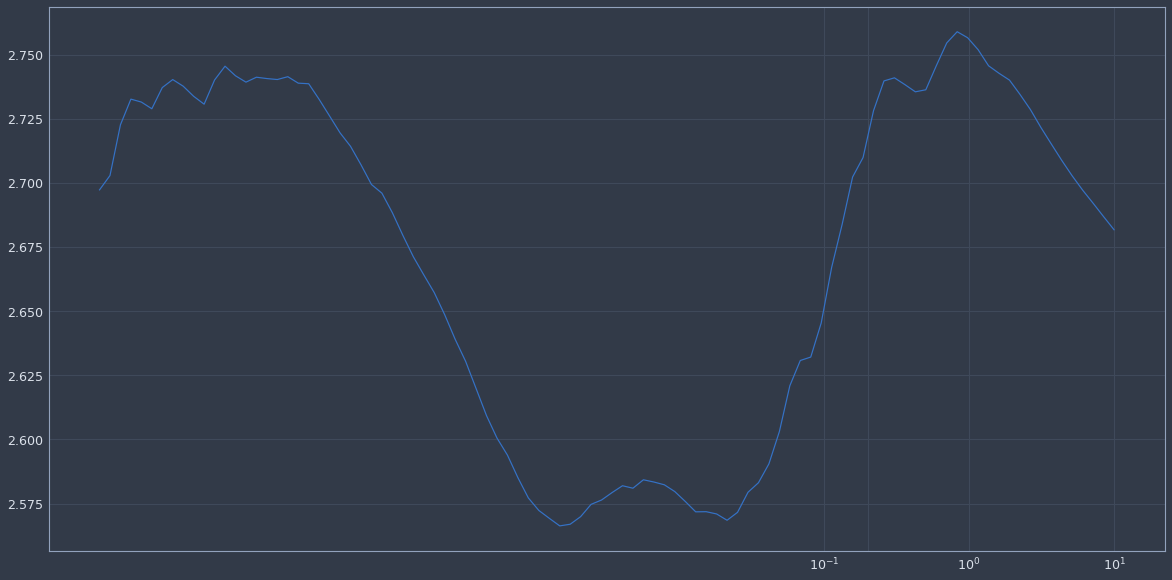

In [25]:
f1, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(lr[60:-2], losses[60:-2])
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
ax1.set_xticks([1e-1,2e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

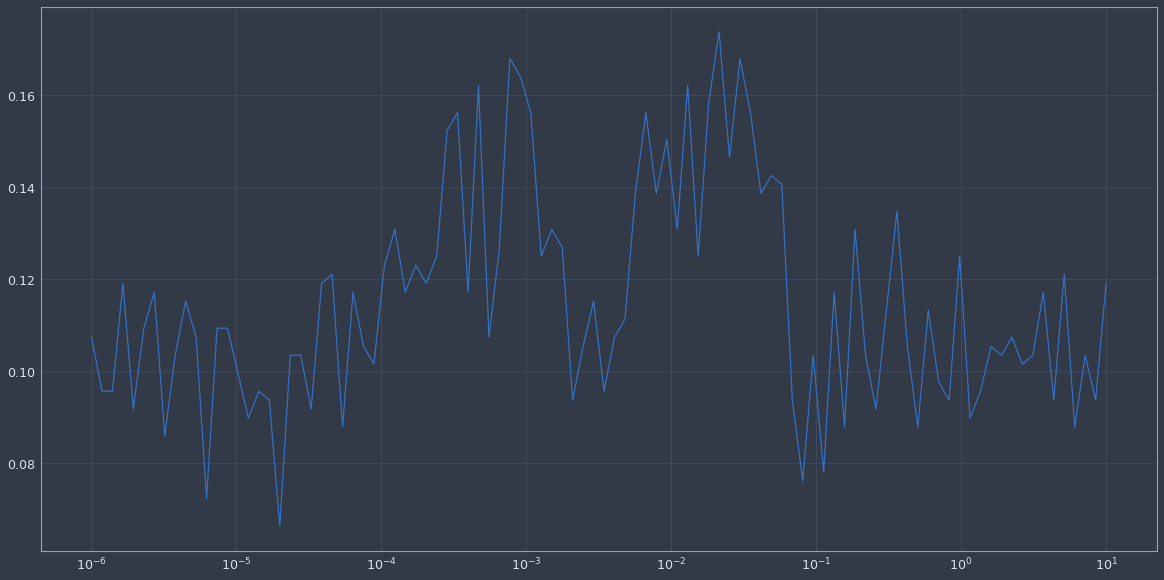

In [26]:

f1, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(lr[60:-2], losses[60:-2])
ax1.plot(lg_lr, accuracies)
ax1.set_xscale('log')
# ax1.set_xticks([1e-1, 2e-1,5e-1, 7e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

In [27]:
model_resnet56 = ResNet56()
optimiser_resnet56 = torch.optim.SGD(model_resnet56.parameters(),
                                     lr=0.1, momentum=0.95,
                                     weight_decay=1e-4)
epochs = 50
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_resnet56, 
                                                max_lr=2e-1, 
                                                steps_per_epoch=len(train_loader), 
                                                epochs = epochs, pct_start=0.43, 
                                                div_factor=10, 
                                                final_div_factor=1000, 
                                                three_phase=True, verbose=False
                                            )
train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs = train(
                                model_resnet56, 
                                optimiser=optimiser_resnet56,
                                scheduler=scheduler,
                                epochs = epochs
                                )

Epoch:0, train cost: 1.865460, val cost: 1.698251, train acc: 0.3119, val acc: 0.408400, total: 50000, lr: 0.020960
Epoch:1, train cost: 1.384178, val cost: 2.044904, train acc: 0.5009, val acc: 0.384000, total: 50000, lr: 0.023820
Epoch:2, train cost: 1.171569, val cost: 1.112582, train acc: 0.5836, val acc: 0.612400, total: 50000, lr: 0.028518
Epoch:3, train cost: 0.988116, val cost: 1.046573, train acc: 0.6529, val acc: 0.637000, total: 50000, lr: 0.034954
Epoch:4, train cost: 0.898876, val cost: 1.365716, train acc: 0.6869, val acc: 0.589200, total: 50000, lr: 0.042991
Epoch:5, train cost: 0.809766, val cost: 0.971279, train acc: 0.7165, val acc: 0.682800, total: 50000, lr: 0.052458
Epoch:6, train cost: 0.742018, val cost: 1.030376, train acc: 0.7420, val acc: 0.667600, total: 50000, lr: 0.063153
Epoch:7, train cost: 0.699589, val cost: 0.771500, train acc: 0.7571, val acc: 0.746000, total: 50000, lr: 0.074847
Epoch:8, train cost: 0.657005, val cost: 1.010518, train acc: 0.7730, va

KeyboardInterrupt: 